# Recommendation system
The two appraches we have under our belt are:



1.   Collaborative filtering 
2.   Content based filtering

We can apply these two appraoches in the task of recommending an item to a user but when recommending items similar to a given item, these two approaches does not make much sense separately. 

So we will make 2 models while recommending posts to a user and only 1 model for recommending posts similar to a given post.

 In collaborative filtering we move forward with the assumption that users who agreed in the past will also agree in the future.

 In content based filtering we are concerned with the features of a single user or post rather than taking account for other users opinion too.

 # What the models are going to do

 
 
1.   Recommend posts for the given user

2.    Recommend similar posts for the given post




 # Description of Data


There are 3 files.
 

*   users.csv Users dataset containing user's details like name, id, gender etc.
*   posts.csv Post dataset containing posts details like title category etc.
*   views.csv Views dataset contains the mapping which user views which post(s)


In [0]:
#import all the basic libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#read data
df_posts_orig = pd.read_csv('/content/posts.csv')
df_users_orig = pd.read_csv('/content/users.csv')
df_views_orig = pd.read_csv('/content/views.csv')

#make a copy of all dataset so that we always have original in hand
df_posts = df_posts_orig 
df_users = df_users_orig 
df_views = df_views_orig


print(df_posts.shape)
print(df_users.shape)
print(df_views.shape)


(493, 4)
(118, 4)
(1449, 3)


So the first thing we do after getting the data in hand is EDA. Analysis is done keeping in mind the final model we are going to make which in this case is a recommendation engine.

In [0]:
#shape of our datsets
print(df_posts.shape)
print(df_users.shape)
print(df_views.shape)

#How the real data looks like
print(df_posts.head())
print(df_users.head())
print(df_views.head())

(493, 4)
(118, 4)
(1449, 3)
                        _id  ...  post_type
0  5d62abaa65218653a132c956  ...       blog
1  5d6d39567fa40e1417a4931c  ...       blog
2  5d7d23315720533e15c3b1ee  ...       blog
3  5d7d405e5720533e15c3b1f3  ...    artwork
4  5d80dfbc6c53455f896e600e  ...       blog

[5 rows x 4 columns]
                        _id                  name gender      academics
0  5d60098a653a331687083238  Nivesh Singh Chauhan   male  undergraduate
1  5d610ae1653a331687083239         Gaurav Sharma   male       graduate
2  5d618359fc5fcf3bdd9a0910         Akshay Mishra   male  undergraduate
3  5d6d2bb87fa40e1417a49315        Saksham Mathur   male  undergraduate
4  5d7c994d5720533e15c3b1e9         Varun Chowhan   male  undergraduate
                    user_id                   post_id                 timestamp
0  5df49b32cc709107827fb3c7  5ec821ddec493f4a2655889e  2020-06-01T10:46:45.131Z
1  5ed3748576027d35905ccaab  5ed4cbadbd514d602c1531a6  2020-06-01T09:39:20.021Z
2  5ed0defa760

In [0]:
#missing values
print(df_posts.isnull().sum())
print(df_users.isnull().sum())
print(df_views.isnull().sum())

_id            0
title          0
category      28
 post_type     0
dtype: int64
_id          0
name         0
gender       0
academics    0
dtype: int64
user_id      0
post_id      0
timestamp    0
dtype: int64


"Apparently" out of all the datasets, only category column of posts data contains null values. I will not fill them right now, it'll be covered while pre-processing the data before feeding it to the final model.

Let's see some visualization that'll help us building an intuition for the recommendation system.



# Recommendation of posts 

We are going to find out posts that are, to some extent, similar to a given post. 
Posts own attributes like title, post type **Plus** the features we get after combining user and posts data using views dataset. We'll be extracting features like user gender and academics who viewed the given post.



undergraduate    68
graduate         48
undefined         2
Name: academics, dtype: int64
object


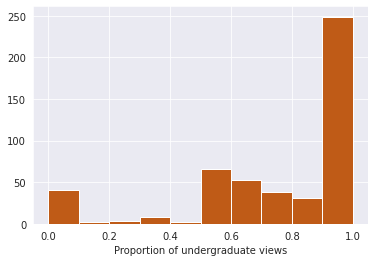

In [0]:
#unique values of academics in users
print(df_users['academics'].value_counts())
print(df_users['academics'].dtype)

#merge the academic background of the audience for a post

empty_list = np.zeros(df_posts.shape[0])

#create two new columns for different qualification
df_posts['undergraduate'] = empty_list
df_posts['graduate'] = empty_list

df_users.set_index('_id', inplace= True)
df_posts.set_index('_id', inplace= True)

for i in range(df_views.shape[0]):
  

  current_user_id = df_views.iloc[i, 0]
  current_post_id = df_views.iloc[i, 1]

  if any(current_user_id == df_users.index) & any(current_post_id == df_posts.index):

    current_user_acad = df_users.loc[current_user_id].academics

    if current_user_acad == 'undergraduate':
      df_posts.loc[current_post_id, 'undergraduate'] += 1

    if current_user_acad == 'graduate':
      df_posts.loc[current_post_id, 'graduate'] += 1


#distribution of views in terms of academics
sns.set_style('darkgrid')
plt.hist(df_posts['undergraduate']/(df_posts['undergraduate'] + df_posts['graduate']))
plt.xlabel('Proportion of undergraduate views')
plt.show()

This plot shows the proportion of undergraduate users viewing a particular post is an indication that a post may attract different audience, for example, any post about project ideas for an undergraduate may only be seen by undergraduates. 
But I cannot ignore the fact that the original distribution of acads is already pretty unbalanced. Maybe this unbalanced distribution will not appear in gender.

We will do a similar distribution of gender too.

male         72
female       44
undefined     2
Name: gender, dtype: int64
object


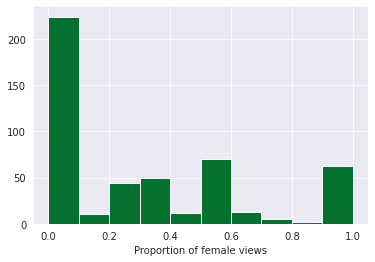

In [0]:
#unique values of gender in users
print(df_users['gender'].value_counts())
print(df_users['gender'].dtype)



#merge the gender of the audience for a post

empty_list = np.zeros(df_posts.shape[0])

#create two new columns for different gender
df_posts['male'] = empty_list
df_posts['female'] = empty_list

for i in range(df_views.shape[0]):
  

  current_user_id = df_views.iloc[i, 0]
  current_post_id = df_views.iloc[i, 1]

  if any(current_user_id == df_users.index) & any(current_post_id == df_posts.index):

    current_user_acad = df_users.loc[current_user_id].gender

    if current_user_acad == 'male':
      df_posts.loc[current_post_id, 'male'] += 1

    if current_user_acad == 'female':
      df_posts.loc[current_post_id, 'female'] += 1

#distribution of views in terms of gender
sns.set_style('darkgrid')
sns.set_palette('BuGn_r')
plt.hist(df_posts['female']/(df_posts['male'] + df_posts['female']))
plt.xlabel('Proportion of female views')
plt.show()




Values greater than 0.5 shows the bias of a post in terms of the gender of its audience.

# The model

We have incorporated user information in each post. Now we will cluster posts using all the features relevant to our analysis. 
For this we have to explore each feature whether it is compatible as the model input or not. 

In [0]:
print(df_posts.dtypes)

title             object
category          object
 post_type        object
undergraduate    float64
graduate         float64
male             float64
female           float64
dtype: object


Data frame of posts has different types of features. Each type will require different pre processing strategy.

In [0]:
print(df_posts['category'].head())
print('\n')
print(df_posts['title'].head())

_id
5d62abaa65218653a132c956                                  Plant Biotechnology
5d6d39567fa40e1417a4931c    Artificial Intelligence|Machine Learning|Infor...
5d7d23315720533e15c3b1ee                                    Operating Systems
5d7d405e5720533e15c3b1f3                                             Drawings
5d80dfbc6c53455f896e600e                                     Competition Laws
Name: category, dtype: object


_id
5d62abaa65218653a132c956                      hello there
5d6d39567fa40e1417a4931c                        Ml and AI
5d7d23315720533e15c3b1ee    What is an Operating System ?
5d7d405e5720533e15c3b1f3                       Lord Shiva
5d80dfbc6c53455f896e600e     How Competition law evolved?
Name: title, dtype: object


These two columns are basically texts. They need to be vectorized before fed into the model. Lets check for 'post type'


In [0]:
print(df_posts[' post_type'].unique())

['blog' 'artwork' 'project' 'skill']


Its is more of a categorical feature than raw text like titles and 'category' columns. 

It will be interesting to see the distribution of this feature.

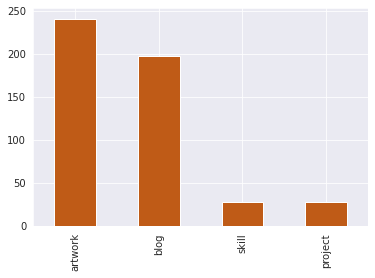

In [0]:
sns.set_style('darkgrid')
sns.set_palette("Accent_r")

df_posts[' post_type'].value_counts().plot(kind= 'bar')

It seems like the website is popular for artwork.  ***Artistic website***.

Now I will finally built the model.

In [0]:
#restore all the columns
df_posts.reset_index(inplace= True)

#Import all necessary lib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, normalize,  StandardScaler
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import re


#Parting numeric, categorical and text features
numeric_features = df_posts.describe().columns
categorical_features = [' post_type']
text_features = ['category', 'title'] 



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Setup is ready, now we will complete the model by feeding the data.

In [0]:
#Import the lib 
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans


# Function get the recommended posts

def recommend_post(title):
  """This function takes post id as input and returns sequence of posts where top post is 
  
      most similar to the given post and last is least similar.
  
      It also prints top 5 posts"""

  # Post recoomendation using only numeric features

  nmf = NMF(n_components= 3)

  features_num = nmf.fit_transform(df_posts[numeric_features])

  df_num = pd.DataFrame(normalize(features_num), index= df_posts['_id'])

  current_post_num = df_num.loc[title]

  similarities_num = df_num.dot(current_post_num)
  
  




  # Post recommendation using only categorical data

  cat_imputer_mapper = DataFrameMapper([
      (' post_type', CategoricalImputer())
                                      ],
      input_df= True,
      df_out= True
  )

  df_cat_non_dict = cat_imputer_mapper.fit_transform(df_posts)

  df_cat_non_vec = df_cat_non_dict.to_dict('record')

  df_cat = DictVectorizer(sort= False).fit_transform(df_cat_non_vec)

  nmf_cat = NMF(n_components = 3)
  features_cat = nmf_cat.fit_transform(df_cat)

  df_cat = pd.DataFrame(normalize(features_cat), index= df_posts['_id'])

  current_post_cat = df_cat.loc[title]

  similarities_cat = df_cat.dot(current_post_cat)

  




  # Post recommendation using only text data
  def combine_text_columns(data_frame):
      """converts all text in each row of data_frame to single vector"""
      
      text_data = df_posts[['title', 'category']]

      # Replace nans with blanks
      text_data.fillna('', inplace= True)

      # Join all text items in a row that have a space in between
      return text_data.apply(lambda x: " ".join(x), axis=1)


  #function to get important words from title and category
  def remove_noise(text, stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]):
      tokens = word_tokenize(text)
      #Alphanumeric characters
      TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
      cleaned_tokens = []
      for token in tokens:
          token = re.sub(TOKENS_ALPHANUMERIC, '', token)
          if len(token) > 2 and token.lower() not in stop_words:
              cleaned_tokens.append(token.lower())

      return cleaned_tokens


  text_data = combine_text_columns(df_posts)

  text_vec = TfidfVectorizer(max_features= 10, tokenizer= remove_noise).fit_transform(text_data)

  features_text = NMF(n_components= 3).fit_transform(text_vec)

  df_text = pd.DataFrame(normalize(features_text), index= df_posts['_id'])

  current_post_text = df_text.loc[title]

  similarities_text = df_text.dot(current_post_text)

  



  #combined similarity of all the recommender
  combined_sim = 0.2*similarities_num + 0.2*similarities_cat + 0.8*similarities_text

  #print titles of recommended posts
  for i in range(5):
    print(df_posts[df_posts['_id'] == combined_sim.nlargest().index[i]].title)


  return(combined_sim.nlargest().index)

_ = recommend_post("5d7d405e5720533e15c3b1f3")




3    Lord Shiva
Name: title, dtype: object
46    OM
Name: title, dtype: object
400    God Drawing
Name: title, dtype: object
100    Mahakaal
Name: title, dtype: object
11    Trident
Name: title, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


These are the posts similar to a post having title 'OM'. 
After processing all the data frame I assigned different weightage to each recommender according to the performance. 

***Note that this recommender system is equally valid in the case of collaborative filtering while recommending posts to a single user.***

This is what I am going to do now. Make a model similar to this one with the only difference, this time we'll be treating user data set as your primary data and extract relevant features from the posts data set.

# Collaborative filtering on user data set

We are assuming that users who viewed a post in past are likely to see the same post in future, again!

In [0]:
import pytz
tz = pytz.timezone('Asia/Kolkata')


df_users.reset_index(inplace= True)

# Function to recommend posts to a user

def rec_byuser(user_id):
  """Takes user id as input and returns 6 posts recommended for the given user.
  
    It returns a list of posts id"""

    
  df_user_spec = df_views[df_views['user_id'] == user_id]

  #change timestamp dtype
  df_views['timestamp'] = pd.to_datetime(df_views['timestamp'], utc= tz)

  latest_viewed_posts = df_user_spec.sort_values('timestamp', ascending= False, ignore_index= True)['post_id'].head(3)

  #get the recommended posts
  recommended_posts = []
  
  for i in range(3):
    rec_posts = recommend_post(latest_viewed_posts[i])
    recommended_posts += rec_posts[:2].tolist()

  for i in range(6):
    print(df_posts[df_posts['_id'] == recommended_posts[i]].title)
    

  return recommended_posts

_ = rec_byuser("5d60098a653a331687083238")

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


489    Configure Docker with Django; PostgreSQL; Pg-a...
Name: title, dtype: object
186    7 Best Python Data Science Courses & Certifica...
Name: title, dtype: object
470    AWS services and how to launch OS on AWS Cloud
Name: title, dtype: object
411    The Basic Edge of Design.
Name: title, dtype: object
1    Ml and AI
Name: title, dtype: object
470    AWS services and how to launch OS on AWS Cloud
Name: title, dtype: object
113    Decision Making with 7 steps !!!
Name: title, dtype: object
132    Textile And Apparel Testing
Name: title, dtype: object
456    Recommend Systems Machine Learning
Name: title, dtype: object
489    Configure Docker with Django; PostgreSQL; Pg-a...
Name: title, dtype: object
455    GAN's Part(2)
Name: title, dtype: object
450    Machine Learning”&“Operations" (MlOps)
Name: title, dtype: object
106    Topology & it's types
Name: title, dtype: object
114    Network & it's types
Name: title, dtype: object
213    8 Free Data Science Courses & Tutorials [2020]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


['5ed3820f76027d35905ccac8',
 '5e81a4f2a3258347b42f21d3',
 '5ed1ff0276027d35905cc60d',
 '5e52e7abd701ab08af7929f8',
 '5ecf96e876027d35905cbf46',
 '5ecd5d417023451e662235c5']

This code is giving us recommeded posts for a user based on the **latest posts** viewed by the user.







Now the only model left is ***content based filtering*** for recommeding a post to a user. 

# Content based filtering

Note that this method is not suitable here(according to me) as it requires few pre requisites, namely:


*   User must be a registered member. This fails for audiences who are just roaming around in the website and they are not registered.
*   A user is required to be a member for a long time and hence give more data to the model for better results.

Here we are assuming that the user might like the same kind of posts he viewed in the past.



In [0]:
df_posts.set_index('_id', inplace= True)



def rec_bypost(user_id):
  """It takes user id as input and returns top 10 posts based on the user history."""

  #Parting numeric, categorical and text features
  numeric_features = df_posts.describe().columns
  categorical_features = [' post_type']
  text_features = ['category', 'title'] 
  posts_viewed = df_views[df_views['user_id'] == user_id]['post_id']

  df_posts['viewed_by'] = np.empty(df_posts.shape[0])

  for post_id in posts_viewed:
    df_posts.loc[post_id, 'viewed_by'] += 1




  #function to get important words from title and category
  def remove_noise(text, stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]):
      tokens = word_tokenize(text)

      cleaned_tokens = []
      for token in tokens:
          token = re.sub(TOKENS_ALPHANUMERIC, '', token)
          if len(token) > 2 and token.lower() not in stop_words:
              cleaned_tokens.append(token.lower())

      return cleaned_tokens

  #Apply Imputer for non_numeric data
  cat_imputer_mapper = DataFrameMapper([
      (' post_type', CategoricalImputer())
                                      ],
      input_df= True,
      df_out= True
  )

  #get numerical features
  get_numeric_features = FunctionTransformer(lambda x: x[numeric_features])

  #get text features
  def combine_text_columns(data_frame):
      """converts all text in each row of data_frame to single vector""" 
      
      text_data = df_posts[['title', 'category']]

      # Replace nans with blanks
      text_data.fillna('', inplace= True)

      # Join all text items in a row that have a space in between
      return text_data.apply(lambda x: " ".join(x), axis=1)

  get_text_features = FunctionTransformer(combine_text_columns)


  #Make separate pipelines
  # Numeric pipeline
  numeric_pipeline = Pipeline([('selector', get_numeric_features)])

  # Categorical pipeline
  Dictifier = FunctionTransformer(lambda x: x.to_dict('record'))
      
  cat_pipeline = Pipeline([
      ('imputer', cat_imputer_mapper),
      ('dictifier', Dictifier),
      ('vectorizer', DictVectorizer(sort= False))
  ])

  # Text pipeline
  text_pipeline = Pipeline([('selector', get_text_features),
                          ('vectorizer', TfidfVectorizer(max_features= 10, tokenizer= remove_noise))
  ])



  #Combine all three pipelines
  union = FeatureUnion([
                        ('numeric_pipe', numeric_pipeline),
                        ('categorical_pipe', cat_pipeline),
                        ('text_pipe', text_pipeline) 
  ])

  #Import the classifier
  from sklearn.linear_model import LinearRegression, Lasso

  pipeline = Pipeline([
                      ('union', union),
                      ('clf', Lasso())
  ])

  pipeline.fit(df_posts.drop('viewed_by', axis= 'columns'), df_posts['viewed_by'])

  n = len(posts_viewed)
  df_to_send = df_posts.drop('viewed_by', axis= 'columns')
  recommendations = pd.Series(pipeline.predict(df_to_send))
  rec_posts_index = recommendations.sort_values(ascending= False)[n:n+10]

  df_posts.reset_index(inplace= True)

  recommended_posts = []
  for i in rec_posts_index.index:
    recommended_posts.append(df_posts.loc[i, '_id'])
    if len(recommended_posts) < 6:
      print(df_posts.loc[i, 'title'])

  return recommended_posts


_ = rec_bypost('5ed0defa76027d35905cc2de')


Ruins.
HUMAN ILLUSTRATION
Faith in yourself
AWS services and how to launch OS on AWS Cloud
Glitch.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


['5ec57acaf2781131cc7e51d5',
 '5ec7a8bdec493f4a26558846',
 '5ecc1d4eeaff6b0c3a58a565',
 '5ed1ff0276027d35905cc60d',
 '5ec5546bf2781131cc7e5140',
 '5ec8204cec493f4a26558893',
 '5ec54fc9f2781131cc7e50f5',
 '5ec7a699ec493f4a2655883a',
 '5ec7a7a3ec493f4a26558840',
 '5ec7ad1aec493f4a26558869']

I have used Lasso regularization in linear regression for this model. 

The function takes in a user_id and prints top 5 recommended posts to the user based on the user self history. 

All three models can be best described by giving one example for each recommender, which model to choose in a specific condition.



1.   ***Recommendation of posts similar to a given post***

The recommendation system here can be used while grouping or making different categories for different posts. Like technical posts, non technical posts etc. This helps the users to navigate their way to the posts they like the most.

2.   ***Recommendation of posts using collaborative filtering***

This system is best suited for situation when we do not want much information of a user but want to recommend good posts to that user. As it incorporates interest of similar users, this is certainly suited for the said situation.
Like for instance, if a user do not sign up on the website but visits it seldom, then the chances of that user signing up later gets high if that user sees content relevant to him. In this case we are providing content to the user without actually knowing their background.

3. ***Recommendation of posts using content filtering***

If a registered user is a frequent visitor of the website then it is most important to retain such loyal users at all cost. Here, the user actually making it easier for us by providing us enough data to recommend him the most relevant content. Content filtering focuses on a single user, so if we have enough data of a single user then it the best method to use.



As we saw, each recommender system has its own kind of advantage. 

